In [3]:
!pip install category_encoders
!pip install toad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 29.4 MB/s eta 0:00:00


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders
from category_encoders import TargetEncoder
import toad
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier


Titanic

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders
from category_encoders import TargetEncoder
import toad

train = pd.read_csv("/content/drive/MyDrive/TitanicTrain.csv")
test = pd.read_csv("/content/drive/MyDrive/TitanicTest.csv")

# 觀察缺失值
print((train.isna().sum()/train.shape[0]).apply(lambda x:format(x,'.2%')))

#觀察類別型
print(train.select_dtypes('O'))

#觀察數值型
print(train.select_dtypes('number'))

PassengerId     0.00%
Survived        0.00%
Pclass          0.00%
Name            0.00%
Sex             0.00%
Age            19.87%
SibSp           0.00%
Parch           0.00%
Ticket          0.00%
Fare            0.00%
Cabin          77.10%
Embarked        0.22%
dtype: object
                                                  Name     Sex  \
0                              Braund, Mr. Owen Harris    male   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
2                               Heikkinen, Miss. Laina  female   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4                             Allen, Mr. William Henry    male   
..                                                 ...     ...   
886                              Montvila, Rev. Juozas    male   
887                       Graham, Miss. Margaret Edith  female   
888           Johnston, Miss. Catherine Helen "Carrie"  female   
889                              Behr, Mr. Karl Howell    male

訓練集處理


In [92]:
# 訓練集處理
train_process = train.set_index(['PassengerId'])
train_process = train_process.drop(['Cabin'],axis=1)

# 獲取名稱中的稱謂類別
train_process['Called'] = train_process['Name'].str.findall('Miss|Mr|Ms').str[0].to_frame()
# 得到名稱長度
train_process['Name_length'] = train_process['Name'].apply(lambda x:len(x))
# 得到FirstName
train_process['First_name'] = train_process['Name'].str.split(',').str[0]

train_process = train_process.drop(['Name'],axis=1)
train_process

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Called,Name_length,First_name
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr,23,Braund
2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mr,51,Cumings
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,22,Heikkinen
4,1,1,female,35.0,1,0,113803,53.1000,S,Mr,44,Futrelle
5,0,3,male,35.0,0,0,373450,8.0500,S,Mr,24,Allen
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,S,NaN,21,Montvila
888,1,1,female,19.0,0,0,112053,30.0000,S,Miss,28,Graham
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,S,Miss,40,Johnston


測試集處理


In [98]:
# 測試集處理
test_process = test.set_index(['PassengerId'])
test_process = test_process.drop(['Cabin'],axis=1)

test_process['Called'] = test_process['Name'].str.findall('Miss|Mr|Ms').str[0].to_frame()
test_process['Name_length'] = test_process['Name'].apply(lambda x:len(x))
test_process['First_name'] = test_process['Name'].str.split(',').str[0]

test_process = test_process.drop(['Name'],axis=1)
test_process

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Called,Name_length,First_name
PassengerId,,,,,,,,,,,
892,3,male,34.5,0,0,330911,7.8292,Q,Mr,16,Kelly
893,3,female,47.0,1,0,363272,7.0000,S,Mr,32,Wilkes
894,2,male,62.0,0,0,240276,9.6875,Q,Mr,25,Myles
895,3,male,27.0,0,0,315154,8.6625,S,Mr,16,Wirz
896,3,female,22.0,1,1,3101298,12.2875,S,Mr,44,Hirvonen
...,...,...,...,...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,A.5. 3236,8.0500,S,Mr,18,Spector
1306,1,female,39.0,0,0,PC 17758,108.9000,C,NaN,28,Oliva y Ocana
1307,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr,28,Saether


特徵編碼

In [99]:
X_train = train_process.iloc[:,1:]
y_train = train_process.iloc[:,0]
X_test = test_process

tar_encoder1 = TargetEncoder(cols=['Sex','Ticket','Embarked','Called','Name_length','First_name'],
                             handle_missing='value',
                             handle_unknown='value')
tar_encoder1.fit(X_train,y_train)

X_train_encode = tar_encoder1.transform(X_train)
X_test_encode = tar_encoder1.transform(X_test)

X_train_encode

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Called,Name_length,First_name
PassengerId,,,,,,,,,,,
1,3,0.188908,22.0,1,0,0.333898,7.2500,0.336957,0.283721,0.295295,0.329391
2,1,0.742038,38.0,1,0,0.464006,71.2833,0.553571,0.283721,0.515799,0.464006
3,3,0.742038,26.0,0,0,0.464006,7.9250,0.336957,0.697802,0.325442,0.464006
4,1,0.742038,35.0,1,0,0.400316,53.1000,0.336957,0.283721,0.526465,0.400316
5,3,0.188908,35.0,0,0,0.333898,8.0500,0.336957,0.283721,0.373163,0.400316
...,...,...,...,...,...,...,...,...,...,...,...
887,2,0.188908,27.0,0,0,0.333898,13.0000,0.336957,0.490615,0.332014,0.333898
888,1,0.742038,19.0,0,0,0.464006,30.0000,0.336957,0.697802,0.373163,0.427526
889,3,0.742038,NaN,1,2,0.329391,23.4500,0.336957,0.697802,0.393419,0.329391


In [100]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 首先對數據進行分割
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 分別對訓練集和驗證集進行缺失值填充
imputer = SimpleImputer(strategy='mean')  # 可以根據需要更改填充策略
X_train_imputed = imputer.fit_transform(X_train_split)
X_valid_imputed = imputer.transform(X_valid)

# 初始化基礎模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

# 繼續進行模型訓練
rf.fit(X_train_imputed, y_train_split)
gb.fit(X_train_imputed, y_train_split)
xgb.fit(X_train_imputed, y_train_split)

# 訓練基礎模型
rf.fit(X_train_imputed, y_train_split)
gb.fit(X_train_imputed, y_train_split)
xgb.fit(X_train_imputed, y_train_split)

# 使用基礎模型進行預測
rf_preds = rf.predict(X_valid_imputed)
gb_preds = gb.predict(X_valid_imputed)
xgb_preds = xgb.predict(X_valid_imputed)

# 堆疊 - 為元模型創建新數據集
stacked_predictions = np.column_stack((rf_preds, gb_preds, xgb_preds))

# 訓練元模型
meta_model = LogisticRegression()
meta_model.fit(stacked_predictions, y_valid)

# 評估元模型性能
stacked_valid_preds = meta_model.predict(stacked_predictions)
print("準確度:", accuracy_score(y_valid, stacked_valid_preds))
print("分類報告:\n", classification_report(y_valid, stacked_valid_preds))

# 對測試數據進行缺失值填充
X_test_imputed = imputer.transform(X_test_encode)

# 使用填充后的X_test_imputed進行預測
rf_test_preds = rf.predict(X_test_imputed)
gb_test_preds = gb.predict(X_test_imputed)
xgb_test_preds = xgb.predict(X_test_imputed)
stacked_test_predictions = np.column_stack((rf_test_preds, gb_test_preds, xgb_test_preds))

# 使用元模型進行最終預測
final_test_predictions = meta_model.predict(stacked_test_predictions)

# 假設測試數據集中有'PassengerId'作為其中的一列final_test_predictions包含您模型的預測結果創建一個包含PassengerId和預測結果的DataFrame
results_df = pd.DataFrame({
'PassengerId': test['PassengerId'],
'Survived': final_test_predictions
})

# 將DataFrame保存為CSV文件
results_df.to_csv('/content/drive/MyDrive/gender_submission.csv', index=False)

print("預測結果已保存到predictions.csv")

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'male'

In [11]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Selected Features and Target Variable:
   Survived  Sex  Survived
0         0    1         0
1         1    0         1
2         1    0         1
3         1    0         1
4         0    1         0


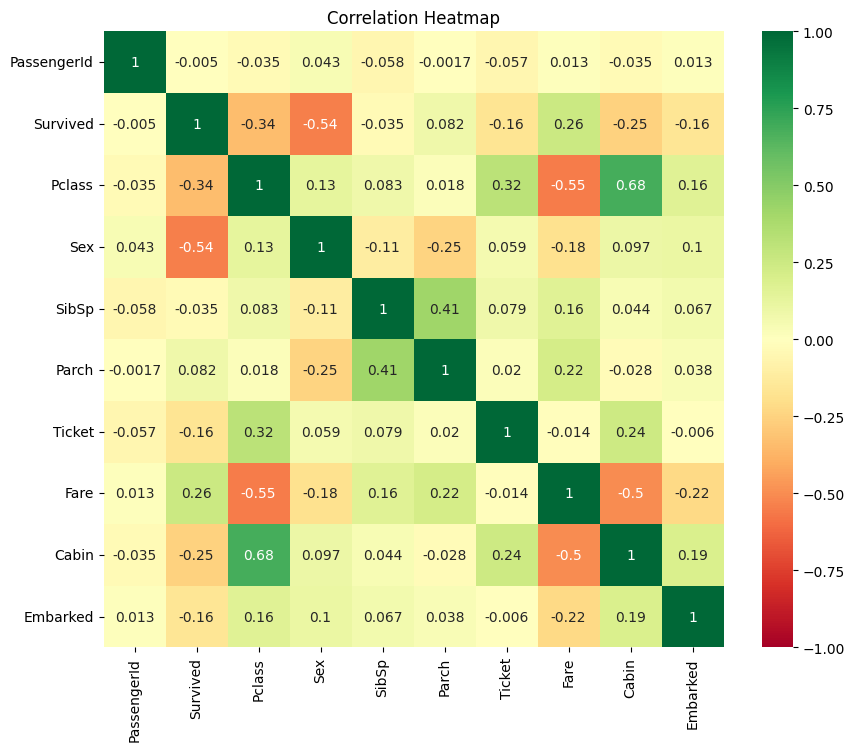

In [41]:
# 提取特徵和目標變數
X = df.drop(['Survived'], axis=1)
y = df['Survived']

# 計算特徵與目標變數的相關係數
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Survived'].abs().sort_values(ascending=False)

# 選擇相關係數大於閾值的特徵
threshold = 0.5
selected_features = correlation_with_target[correlation_with_target > threshold].index.tolist()

# 保留選擇的特徵及目標變數
selected_df = df[selected_features + ['Survived']]

# 顯示選擇的特徵及目標變數
print("Selected Features and Target Variable:")
print(selected_df.head())

# 繪製特徵與目標變數的相關係數熱力圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [57]:


X = df.drop(['Survived'], axis=1)
y = df['Survived']

# 創建梯度提升樹模型
model = RandomForestClassifier()

# 訓練模型
model.fit(X, y)

# 獲取特徵重要性
feature_importance = model.feature_importances_

# 建立特徵重要性的DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# 根據特徵重要性降序排列
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 打印特徵重要性
print("Feature Importance:")
print(feature_importance_df)


Feature Importance:
       Feature  Importance
2          Sex    0.256187
5       Ticket    0.195457
0  PassengerId    0.167435
6         Fare    0.152330
7        Cabin    0.068815
1       Pclass    0.065921
4        Parch    0.035886
3        SibSp    0.033468
8     Embarked    0.024501


In [67]:
# 切分特徵和目標變數
X = df.drop(['Survived', 'PassengerId'], axis=1)
y = df['Survived']

# 資料打亂
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#進行數據降採樣
undersampler = RandomUnderSampler(random_state=1)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# MinMax正规化
scaler = MinMaxScaler()
X_train_undersampled = scaler.fit_transform(X_train_undersampled)
X_test = scaler.transform(X_test)

# 建立隨機森林模型
rf = RandomForestClassifier(random_state=1)

# 一對一法（One-vs-One）
ovo = OneVsOneClassifier(rf)
ovo.fit(X_train_undersampled, y_train_undersampled)
ovo_pred = ovo.predict(X_test)
ovo_accuracy = accuracy_score(y_test, ovo_pred)
ovo_precision = precision_score(y_test, ovo_pred, average='macro')
ovo_recall = recall_score(y_test, ovo_pred, average='macro')
ovo_f1 = f1_score(y_test, ovo_pred, average='macro')
ovo_cm = confusion_matrix(y_test, ovo_pred)
ovo_kappa = cohen_kappa_score(y_test, ovo_pred)

# 一對多法（One-vs-All）
ova = OneVsRestClassifier(rf)
ova.fit(X_train_undersampled, y_train_undersampled)
ova_pred = ova.predict(X_test)
ova_accuracy = accuracy_score(y_test, ova_pred)
ova_precision = precision_score(y_test, ova_pred, average='macro')
ova_recall = recall_score(y_test, ova_pred, average='macro')
ova_f1 = f1_score(y_test, ova_pred, average='macro')
ova_cm = confusion_matrix(y_test, ova_pred)
ova_kappa = cohen_kappa_score(y_test, ova_pred)

# 多對多法（Many-vs-Many）
mvc = OutputCodeClassifier(rf)
mvc.fit(X_train_undersampled, y_train_undersampled)
mvc_pred = mvc.predict(X_test)
mvc_accuracy = accuracy_score(y_test, mvc_pred)
mvc_precision = precision_score(y_test, mvc_pred, average='macro')
mvc_recall = recall_score(y_test, mvc_pred, average='macro')
mvc_f1 = f1_score(y_test, mvc_pred, average='macro')
mvc_cm = confusion_matrix(y_test, mvc_pred)
mvc_kappa = cohen_kappa_score(y_test, mvc_pred)

# 打印評估結果
print("One-vs-One Accuracy:", ovo_accuracy)
print("One-vs-One Precision:", ovo_precision)
print("One-vs-One Recall:", ovo_recall)
print("One-vs-One F1 Score:", ovo_f1)
print("One-vs-One Cohen's Kappa:", ovo_kappa)
print()
print("One-vs-All Accuracy:", ova_accuracy)
print("One-vs-All Precision:", ova_precision)
print("One-vs-All Recall:", ova_recall)
print("One-vs-All F1 Score:", ova_f1)
print("One-vs-All Cohen's Kappa:", ova_kappa)
print()
print("Many-vs-Many Accuracy:", mvc_accuracy)
print("Many-vs-Many Precision:", mvc_precision)
print("Many-vs-Many Recall:", mvc_recall)
print("Many-vs-Many F1 Score:", mvc_f1)
print("Many-vs-Many Cohen's Kappa:", mvc_kappa)


One-vs-One Accuracy: 0.7877094972067039
One-vs-One Precision: 0.7813570487483531
One-vs-One Recall: 0.7759757043163609
One-vs-One F1 Score: 0.7782342201356286
One-vs-One Cohen's Kappa: 0.5566996871741396

One-vs-All Accuracy: 0.7877094972067039
One-vs-All Precision: 0.7813570487483531
One-vs-All Recall: 0.7759757043163609
One-vs-All F1 Score: 0.7782342201356286
One-vs-All Cohen's Kappa: 0.5566996871741396

Many-vs-Many Accuracy: 0.7877094972067039
Many-vs-Many Precision: 0.7813570487483531
Many-vs-Many Recall: 0.7759757043163609
Many-vs-Many F1 Score: 0.7782342201356286
Many-vs-Many Cohen's Kappa: 0.5566996871741396
